<center style = "font-size:2em;"> COSC 522 Project 1</center>
<center style = "font-size:1em;">Yangsong Gu </center>

<center style = "font-size:1em;">Sep 6, 2021 </center>

- modified decision boundary 
- revised accuracy performance class-wise accuracy 13:16 Sep 24 2021


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sympy import lambdify
from sympy import Symbol, symbols, simplify
import sympy

In [38]:
df_tr = pd.read_csv('http://www.stats.ox.ac.uk/pub/PRNN/synth.tr', delim_whitespace = True, header = 0)
df_te = pd.read_csv('http://www.stats.ox.ac.uk/pub/PRNN/synth.te', delim_whitespace = True, header = 0)

In [39]:
df_tr.shape, df_tr.yc.unique()

((250, 3), array([0, 1], dtype=int64))

In [40]:
Xtrain = df_tr[['xs','ys']].to_numpy()
ytrain = df_tr['yc'].to_numpy().astype(int)

Xtest = df_te[['xs','ys']].to_numpy()
ytest = df_te['yc'].to_numpy().astype(int)

nte, nf = Xtest.shape    # get the dimension of testing samples
                         # nte is the number of testing samples
                         # nf is the number of features/dimensions
class_n = len(df_tr.yc.unique())   
class_n

2

In [41]:
# get training samples for class 0
arr = Xtrain[ytrain == 0]
covs0 = np.cov(np.transpose(arr))
means0 = np.mean(arr, axis = 0)

In [42]:
arr = Xtrain[ytrain == 1]
covs1 = np.cov(np.transpose(arr))
means1 = np.mean(arr, axis = 0)
print("cov. of 1", covs1, "mean of 1", means1)

cov. of 1 [[ 0.15974786 -0.01557501]
 [-0.01557501  0.02995842]] mean of 1 [0.07595431 0.68296891]


In [43]:
def model_evaluation(y, ytest, t1, t0):
    '''
    performance evaluation: 
    1) overal classification accuracy
    2) calculate the classwise classification accuracy.
    3) elapsed time
    
    input: y        --> prediciton
           ytest    --> truth
    output: acc_overall --> overall accuracy
            acc0    --> accuracy of class 0
            acc1    --> accuracy of class 1
            runtime --> elapsed time
    '''
    
    # overall classfication accuracy 
    acc_overall = np.count_nonzero(y == ytest) / len(y)
    
    # classwise classfication accuracy
    pt00 = ((np.array(y) == 0) & (ytest==0)).sum()  # predict is 0, truth is 0 
    pt10 = ((np.array(y) == 0) & (ytest==1)).sum()  # predict is 0, truth is 1 
    pt01 = ((np.array(y) == 1) & (ytest==0)).sum()  # predict is 1, truth is 0
    pt11 = ((np.array(y) == 1) & (ytest==1)).sum()  # predict is 1, truth is 1
    # classwise accuracy 
#     acc0 = pt00 / (pt00 + pt10)                     # classwise accuracy of clas 0
#     acc1 = pt11 / (pt01 + pt11)                     # classwise accuracy of class 1
    # edit on 9/24/2021
    acc0 = pt00/(pt00 + pt01)                         # updated classwise accuracy of class 0 
    acc1 = pt11/(pt10 + pt11)                         # updated classwise accuracy of class 1
    
    # elapsed time
    runtime = t1 - t0
    print( 'Overall accuracy: {:.2%}'.format(acc_overall), '\n',
        'Classwise accuracy of class 0: {:.2%}'.format(acc0), '\n',
          'Classwise accuracy of class 1: {:.2%}'.format(acc1), '\n',
          'Test finished in {:.4f} seconds'.format(runtime))
    
    return acc_overall, acc0, acc1, runtime 

### 1) Minimum Euclidean distance classifier (Linear machine)

In [44]:
# modified varavg on 9/22/2021 20:46

In [45]:
t0 = time.time()
covavg = (covs0 + covs1) / 2  
varavg = np.sum(np.diagonal(covavg)) / class_n  # average of variances, modified on 9/22/2021
Pw0 = Pw1 = 0.5            # assume the equal priority 
y = []                     # save the classification label of testing samples
for i in range(nte):
    
    edist2 = np.dot(Xtest[i] - means0, Xtest[i] - means0)
    g0 = -edist2 / (2 * varavg) + np.log(Pw0)
    
    edist2 = np.dot(Xtest[i] - means1, Xtest[i] - means1)
    g1 = -edist2 / (2 * varavg) + np.log(Pw1)
    
    y.append(1) if g1 > g0 else y.append(0)

t1 = time.time()

acc_overall, acc0, acc1, runtime = model_evaluation(y, ytest, t1, t0)



Overall accuracy: 71.30% 
 Classwise accuracy of class 0: 68.00% 
 Classwise accuracy of class 1: 74.60% 
 Test finished in 0.0240 seconds


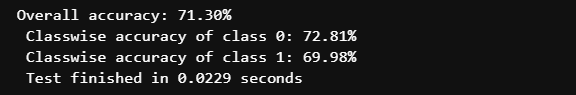

### 2) minimum Mahalanobis distance classifier (linear machine)

Assume the covariance matrix is $$\sum_i = \sum = \frac{covs1+ covs2}{2}
                            $$

In [14]:
t0 = time.time()
covavg = (covs0 + covs1) / 2                # average of Sigmas
Pw0 = Pw1 = 0.5
y = []

for i in range(nte):
    
    mdist = np.transpose(Xtest[i] - means0) @ np.linalg.inv(covavg) @ (Xtest[i] - means0)
    g0 = -mdist/2 + np.log(Pw0)           # mahalanobis distance 
    
    mdist = np.transpose(Xtest[i] - means1) @ np.linalg.inv(covavg) @ (Xtest[i] - means1)
    g1 = -mdist/2 + np.log(Pw1)
    
    y.append(1) if g1 > g0 else y.append(0)

t1 = time.time()

acc_overall, acc0, acc1, runtime = model_evaluation(y, ytest, t1, t0)

Overall accuracy: 89.20% 
 Classwise accuracy of class 0: 90.00% 
 Classwise accuracy of class 1: 88.40% 
 Test finished in 0.0947 seconds


### 3) the generic form of Baysian decision rule (quadratic machine)

In [32]:
t0 = time.time()
Pw0 = Pw1 = 0.5
y = []

for i in range(nte):
    
    qdist = np.transpose(Xtest[i] - means0) @ np.linalg.inv(covs0) @ (Xtest[i] - means0)
    g0 = -qdist/2 - 0.5 * np.log(np.linalg.det(covs0)) + np.log(Pw0)           # mahalanobis distance 
    
    qdist = np.transpose(Xtest[i] - means1) @ np.linalg.inv(covs1) @ (Xtest[i] - means1)
    g1 = -qdist/2 - 0.5 * np.log(np.linalg.det(covs1)) + np.log(Pw1)
    
    y.append(1) if g1 > g0 else y.append(0)

t1 = time.time()
acc_overall, acc0, acc1, runtime = model_evaluation(y, ytest, t1, t0)


Overall accuracy: 74.10% 
 Classwise accuracy of class 0: 61.47% 
 Classwise accuracy of class 1: 80.27% 
 Test finished in 0.0598 seconds


(0.7409638554216867,
    category  cate_size  class_acc
 0         0        109   0.614679
 1         1        223   0.802691)

### Tasks

Show a scatter plot of the training set of the two classes using only the synthetic dataset. From visual inspection, do you think single-modal Gaussian is a good/reasonable model for the pdf?

Text(0, 0.5, 'feature 2')

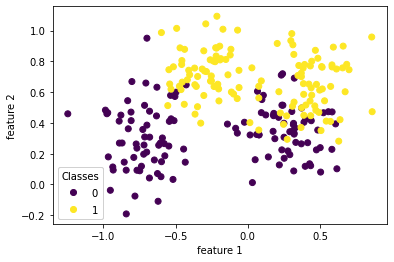

In [17]:
fig, ax = plt.subplots()
scatter = ax.scatter(df_tr['xs'], df_tr['ys'], c = df_tr['yc'])
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
# plt.savefig("../Figures/scatterplot of test sample.jpg")

Using only the synthetic dataset, illustrate the three decision boundaries from the three cases of parametric learning algorithms on the same figure as the scatter plot of the testing dataset. Comment on the differences.

Euclidean distance

In [ ]:
# modified on Sep 19, 2021, use the training set to compute means 

In [48]:
means = df_tr.groupby('yc').mean()
display(means)
means = means.to_numpy()
x1, x2 = symbols('x1 x2',real = True)
edist = - 2 * (means[0,0] * x1 + means[0,1] * x2) + 2 * (means[1,0] * x1 + means[1,1] * x2) + \
        + means[0,0]**2 + means[0,1]**2 - (means[1,0]**2 + means[1,1]**2)
edist = simplify(edist)
display(edist)

xx = np.linspace(-1.5, 2, 100)
# coeff = -0.5057 / 0.8145  
# intercept = 0.3632/0.8145
coeffs = sympy.Poly(edist, x1, x2).coeffs()

coeff = -coeffs[0]/coeffs[1]
intercept  = -coeffs[2]/coeffs[1]
yy_edist = xx * coeff + intercept
print(coeff, intercept)

,xs,ys
yc,,
0,-0.221470,0.325755
1,0.075954,0.682969


0.59484910208*x1 + 0.71442794512*x2 - 0.317050246919288

-0.832622948392767 0.443781978413561


Manhalanobis distance

In [49]:
dist0 = sympy.Matrix([x1, x2]) - means[0,:].reshape(2,1)
dist1 = sympy.Matrix([x1, x2]) - means[1,:].reshape(2,1)
gx = dist0.transpose() @ np.linalg.inv(covavg) @ dist0 - dist1.transpose() @ np.linalg.inv(covavg) @ dist1
gx = simplify(gx)
display(gx)
# coeff = - 2.5638 / 24.8217  
# intercept = 12.0248/24.8217 
# coeff = -2.94239558705424/21.8174879666796
# intercept = 10.7898275662935/21.8174879666799
coeffs = sympy.Poly(gx[0], x1, x2).coeffs()
coeff = -coeffs[0]/coeffs[1]
intercept  = -coeffs[2]/coeffs[1]

yy_mdist = xx * coeff + intercept

print(coeff, intercept)


Matrix([[2.94239558705424*x1 + 21.8174879666796*x2 - 10.7898275662935]])

-0.134864086623903 0.494549490884199


Quadratic machine

In [50]:
left = -0.5 * dist0.transpose()  @ np.linalg.inv(covs0) @ dist0 - 0.5 * np.log(np.linalg.det(covs0)).reshape(1,1) 
right = -0.5 * dist1.transpose()  @ np.linalg.inv(covs1) @ dist1 - 0.5 * np.log(np.linalg.det(covs1)).reshape(1,1)
gx = left - right
gx = simplify(gx)
display("Discriminant function", gx)    
var = (x1, x2)
gx_func = lambdify(var, gx, modules = 'numpy')
gx_y = gx_func(xx, x2)

# iterate and solve equations
gx_y_list = gx_y.flatten('C').tolist()
yy = [sympy.solve(formula, x2) for formula in gx_y_list]

yy_real = [item for sublist in yy for item in sublist]
yy_qdist= [yy_final for yy_final in yy if len(yy_final)>0]
yy_qdist = [item for sublist in yy_qdist for item in sublist]
xx_qdist = np.repeat(xx[:int(len(yy_real)/2)],2).tolist()


'Discriminant function'

Matrix([[1.46768684748451*x1**2 + 4.56561613528624*x1*x2 - 4.02302130593299*x1 + 3.56103245543681*x2**2 - 14.8888425980496*x2 + 6.34986103776841]])

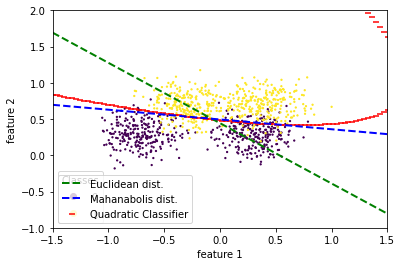

In [51]:
fig, ax = plt.subplots()
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1,2])
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
scatter = ax.scatter(df_te['xs'], df_te['ys'], c = df_te['yc'],s = 1.6)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
ax.plot(xx, yy_edist, color = 'g',linestyle = '--',linewidth = 2, label = 'Euclidean dist.')
ax.plot(xx, yy_mdist, color = 'b', linestyle = '--', linewidth = 2, label = 'Mahanabolis dist.')
ax.scatter(xx_qdist, yy_qdist, c= 'r', marker = "_", label = 'Quadratic Classifier')
ax.legend()
# plt.savefig('../Figures/decisionboundary.jpg')

Plot a figure with 3x2 subplots of class-0 accuracy vs. ratio of prior probability on the two datasets of the three cases of MAP classifiers and provide comments and discussions.
(5 pts) Final discussion.

In [15]:
Pw0 = np.linspace(0.1,0.9,10)

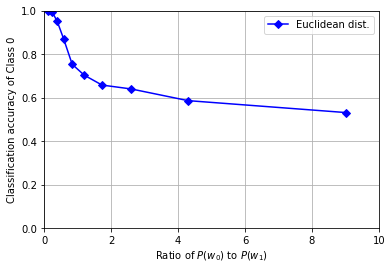

In [16]:
def eculidean_class(Xtest,ytest,means0,means1, covs0, covs1, nf, Pw0, nte):
    
    covavg = (covs0 + covs1) / 2  
    varavg = np.sum(np.diagonal(covavg) /) 2   # average of variances  Edit on sep 22. 2021
#     Pw0 = Pw1 = 0.5            # assume the equal priority 
    Pw1 = 1 - Pw0
    y = []                     # save the classification label of testing samples
    
    for i in range(nte):

        edist2 = np.dot(Xtest[i] - means0, Xtest[i] - means0)
        g0 = -edist2 / (2 * varavg) + np.log(Pw0)

        edist2 = np.dot(Xtest[i] - means1, Xtest[i] - means1)
        g1 = -edist2 / (2 * varavg) + np.log(Pw1)

        y.append(1) if g1 > g0 else y.append(0)

    # classwise classfication accuracy
    pt00 = ((np.array(y) == 0) & (ytest==0)).sum()  # predict is 0, truth is 0 
    pt10 = ((np.array(y) == 0) & (ytest==1)).sum()  # predict is 1, truth is 0  
    # classwise accuracy 
    acc0 = pt00 / (pt00 + pt10) 
    
    return [Pw0, acc0]  

Res = []  # save results
for pw0 in Pw0:
    
    res = eculidean_class(Xtest,ytest,means0,means1, covs0, covs1, nf, Pw0, nte)
    
    Res.append(res)
    
Res_arry = np.array(Res)  # conver 2d list to 2d array
                          # first col is prior prob of class 0
                          # second col is the accuracy of class 0

plt.plot(Res_arry[:,0]/(1 - Res_arry[:,0]), Res_arry[:,1], color = 'b', marker = 'D', label = 'Euclidean dist.')
plt.xlabel('Ratio of $P(w_0)$ to $P(w_1)$')
plt.ylabel('Classification accuracy of Class 0')
plt.legend()
plt.ylim([0,1])
plt.xlim([0,10])
plt.grid()
plt.savefig(r'../Figures/sy_edist_2.jpg')

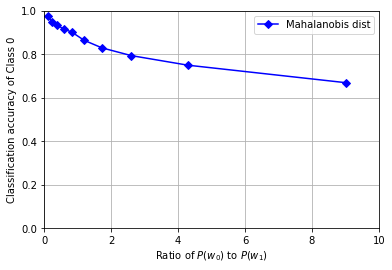

In [17]:
def mahalabolis_class(Xtest,ytest,means0,means1,covs0, covs1, nf, Pw0, nte):
    '''
    mahalanobis distance 
    '''
    covavg = (covs0 + covs1) / 2                # average of Sigmas
    Pw1 = 1 - Pw0
    y = []

    for i in range(nte):

        mdist = np.transpose(Xtest[i] - means0) @ np.linalg.inv(covavg) @ (Xtest[i] - means0)
        g0 = -mdist/2 + np.log(Pw0)           # mahalanobis distance 

        mdist = np.transpose(Xtest[i] - means1) @ np.linalg.inv(covavg) @ (Xtest[i] - means1)
        g1 = -mdist/2 + np.log(Pw1)

        y.append(1) if g1 > g0 else y.append(0)
        
    # classwise classfication accuracy
    pt00 = ((np.array(y) == 0) & (ytest==0)).sum()  # predict is 0, truth is 0 
    pt10 = ((np.array(y) == 0) & (ytest==1)).sum()  # predict is 1, truth is 0  
    # classwise accuracy 
    acc0 = pt00 / (pt00 + pt10) 
    
    return [Pw0, acc0] 
    
Res = []  # save results
for pw0 in Pw0:
    
    res = mahalabolis_class(Xtest,ytest,means0,means1,covs0, covs1, nf, Pw0, nte)
    Res.append(res)
    
Res_arry = np.array(Res)  # conver 2d list to 2d array
                          # first col is prior prob of class 0
                          # second col is the accuracy of class 0
plt.plot(Res_arry[:,0]/(1 - Res_arry[:,0]), Res_arry[:,1], color = 'b', marker = 'D', label = 'Mahalanobis dist')
plt.xlabel('Ratio of $P(w_0)$ to $P(w_1)$')
plt.ylabel('Classification accuracy of Class 0')
plt.legend()
plt.ylim([0,1])
plt.xlim([0,10])
plt.grid()
plt.savefig(r'../Figures/sy_mdist_2.jpg')

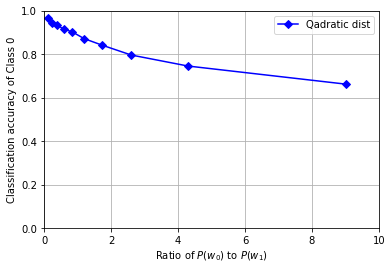

In [18]:
def quadratic_class(Xtest,ytest, means0,means1,covs0, covs1, nf, Pw0, nte):
    '''
    quadratic classifier
    '''
    y = []
    Pw1 = 1 - Pw0
    for i in range(nte):

        qdist = np.transpose(Xtest[i] - means0) @ np.linalg.inv(covs0) @ (Xtest[i] - means0)
        g0 = -qdist/2 - 0.5 * np.log(np.linalg.det(covs0)) + np.log(Pw0)           # mahalanobis distance 

        qdist = np.transpose(Xtest[i] - means1) @ np.linalg.inv(covs1) @ (Xtest[i] - means1)
        g1 = -qdist/2 - 0.5 * np.log(np.linalg.det(covs1)) + np.log(Pw1)

        y.append(1) if g1 > g0 else y.append(0)
        
        
    # classwise classfication accuracy
    pt00 = ((np.array(y) == 0) & (ytest==0)).sum()  # predict is 0, truth is 0 
    pt10 = ((np.array(y) == 0) & (ytest==1)).sum()  # predict is 1, truth is 0  
    # classwise accuracy 
    acc0 = pt00 / (pt00 + pt10) 
    
    return [Pw0, acc0] 


Res = []  # save results
for pw0 in Pw0:
    
    res = quadratic_class(Xtest, ytest,means0,means1,covs0, covs1, nf, pw0, nte)
    
    Res.append(res)
    
Res_arry = np.array(Res)  # conver 2d list to 2d array
                          # first col is prior prob of class 0
                          # second col is the accuracy of class 0
        
plt.plot(Res_arry[:,0]/(1 - Res_arry[:,0]), Res_arry[:,1], color = 'b', marker = 'D', label = 'Qadratic dist')
plt.xlabel('Ratio of $P(w_0)$ to $P(w_1)$')
plt.ylabel('Classification accuracy of Class 0')
plt.legend()
plt.ylim([0,1])
plt.xlim([0,10])
plt.grid()
plt.savefig(r'../Figures/sy_qdist_2.jpg')

# Pima dataset

In [16]:
df_tr = pd.read_csv(r'http://www.stats.ox.ac.uk/pub/PRNN/pima.tr',delim_whitespace = True, header = 0)
df_te = pd.read_csv(r'http://www.stats.ox.ac.uk/pub/PRNN/pima.te',delim_whitespace = True, header = 0)

In [17]:
df_tr = df_tr.replace({'No': 1, 'Yes':0})
df_te = df_te.replace({'No': 1, 'Yes':0})

In [18]:
# standard normalization for training set
f_mean  = df_tr.iloc[:,:-1].mean(axis = 0)
f_std = df_tr.iloc[:,:-1].std(axis = 0)
nor_tr = (df_tr.iloc[:,:-1] - f_mean)/f_std

# standard normalization for training set
nor_te= (df_te.iloc[:,:-1] - f_mean)/f_std

class_n = df_tr.iloc[:,-1].unique().shape[0]
class_n

2

In [19]:
df_te
varavg = np.sum(np.diagonal(covavg) / nf) 
varavg

0.125658722854769

In [20]:
Xtrain = nor_tr.to_numpy()
ytrain = df_tr['type'].to_numpy().astype(int)

Xtest = nor_te.to_numpy()
ytest = df_te['type'].to_numpy().astype(int)

nte, nf = Xtest.shape    # get the dimension of testing samples
                         # nte is the number of testing samples
                         # nf is the number of features/dimensions
print("number of featues is: ",nf, "number of testing samples is:", nte, "number of training samples is:", Xtrain.shape[0])

number of featues is:  7 number of testing samples is: 332 number of training samples is: 200


In [21]:
# get training samples for class 0
arr = Xtrain[ytrain == 0]
covs0 = np.cov(np.transpose(arr))
means0 = np.mean(arr, axis = 0)

arr = Xtrain[ytrain == 1]
covs1 = np.cov(np.transpose(arr))
means1 = np.mean(arr, axis = 0)

In [27]:
def accuracy_score(y, y_model):
    """ Return accuracy score.
    You are supposed to return both overall accuracy and classwise accuracy.
    args   y --> label of test sample
           y_model --> label generated from the algorithm, which is a list.
    return acc_overall --> overall accuracy, a scalar
           acc_classwise   --> classwise accuracy a dataframe
    """
    y = y.tolist() if isinstance(y, pd.Series) else y  # if y is a pd.Series, then convert it to list

    assert len(y) == len(y_model)

    # overall accuracy
    unq_label = np.unique(y)       # unique label

    # classwie accuracy, should consider situations with desigated dimensions
    # use pandas groupby
    # create a pandas dataframe
    df_eval = pd.DataFrame(list(zip(y, y_model)),
               columns =['ytest', 'ymodel'])
    df_eval['acc'] = (df_eval['ytest'] == df_eval['ymodel']).astype(int)
    category_size = df_eval.groupby(['ytest'])['ymodel'].count().reset_index()  # count the samples in each category
    category_acc  = df_eval.groupby(['ytest'])['acc'].sum().reset_index()        # number of accurate label

    acc_classwise = pd.merge(category_size, category_acc, on = 'ytest',validate = 'one_to_one')
    acc_classwise['acc'] = acc_classwise['acc']/acc_classwise['ymodel']
    acc_classwise = acc_classwise.rename(columns = {'ytest':'category','ymodel':'cate_size','acc':'class_acc'})

    # overall accuracy
    acc_overall = df_eval['acc'].sum()/df_eval.shape[0]

    return acc_overall, acc_classwise


In [25]:
# Euclidean distance 
t0 = time.time()
Pw0 = Pw1 = 0.5
covavg = (covs0 + covs1) / 2  
varavg = np.sum(np.diagonal(covavg))/class_n   # average of variances
y = []                     # save the classifiation label of testing samples
for i in range(nte):
    
    edist2 = np.dot(Xtest[i] - means0, Xtest[i] - means0)
    g0 = -edist2 / (2 * varavg) + np.log(Pw0)
    
    edist2 = np.dot(Xtest[i] - means1, Xtest[i] - means1)
    g1 = -edist2 / (2 * varavg) + np.log(Pw1)
    
    y.append(1) if g1 > g0 else y.append(0)

t1 = time.time()

acc_overall, acc0, acc1, runtime = model_evaluation(y, ytest, t1, t0)

Overall accuracy: 74.10% 
 Classwise accuracy of class 0: 70.64% 
 Classwise accuracy of class 1: 75.78% 
 Test finished in 0.0079 seconds


In [30]:
# mahalanobis distance
t0 = time.time()
Pw0 = Pw1 = 0.5
covavg = (covs0 + covs1) / 2                # average of Sigmas
y = []

for i in range(nte):
    
    mdist = np.transpose(Xtest[i] - means0) @ np.linalg.inv(covavg) @ (Xtest[i] - means0)
    g0 = -mdist/2 + np.log(Pw0)           # mahalanobis distance 
    
    mdist = np.transpose(Xtest[i] - means1) @ np.linalg.inv(covavg) @ (Xtest[i] - means1)
    g1 = -mdist/2 + np.log(Pw1)
    
    y.append(1) if g1 > g0 else y.append(0)

t1 = time.time()
acc_overall, acc0, acc1, runtime = model_evaluation(y, ytest, t1, t0)


Overall accuracy: 76.81% 
 Classwise accuracy of class 0: 72.48% 
 Classwise accuracy of class 1: 78.92% 
 Test finished in 0.0579 seconds


(0.7680722891566265,
    category  cate_size  class_acc
 0         0        109   0.724771
 1         1        223   0.789238)

In [31]:
# generic gaussian classifier
t0 = time.time()
Pw0 = Pw1 = 0.5
y = []
for i in range(nte):
    
    qdist = np.transpose(Xtest[i] - means0) @ np.linalg.inv(covs0) @ (Xtest[i] - means0)
    g0 = -qdist/2 - 0.5 * np.log(np.linalg.det(covs0)) + np.log(Pw0)           # mahalanobis distance 
    
    qdist = np.transpose(Xtest[i] - means1) @ np.linalg.inv(covs1) @ (Xtest[i] - means1)
    g1 = -qdist/2 - 0.5 * np.log(np.linalg.det(covs1)) + np.log(Pw1)
    
    y.append(1) if g1 > g0 else y.append(0)

t1 = time.time()
acc_overall, acc0, acc1, runtime = model_evaluation(y, ytest, t1, t0)


Overall accuracy: 74.10% 
 Classwise accuracy of class 0: 61.47% 
 Classwise accuracy of class 1: 80.27% 
 Test finished in 0.0748 seconds


(0.7409638554216867,
    category  cate_size  class_acc
 0         0        109   0.614679
 1         1        223   0.802691)

In [28]:
# plot 3x2 subplots of class-0 accuracy vs. ratio of prior probability 

In [29]:
Pw0 = np.linspace(0.1,0.9,10)

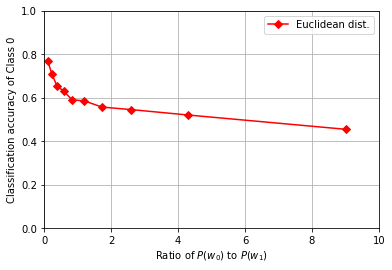

In [30]:
# Minimum Euclidean distance
Res = []  # save results
for pw0 in Pw0:
    
    res = eculidean_class(covs0, covs1, nf, pw0, nte)
    
    Res.append(res)
    
Res_arry = np.array(Res)  # conver 2d list to 2d array
                          # first col is prior prob of class 0
                          # second col is the accuracy of class 0
plt.plot(Res_arry[:,0]/(1 - Res_arry[:,0]), Res_arry[:,1], color = 'r', marker = 'D', label = 'Euclidean dist.')
plt.xlabel('Ratio of $P(w_0)$ to $P(w_1)$')
plt.ylabel('Classification accuracy of Class 0')
plt.legend()
plt.ylim([0,1])
plt.xlim([0,10])
plt.grid()
plt.savefig(r'../Figures/pm_edist_2.jpg')

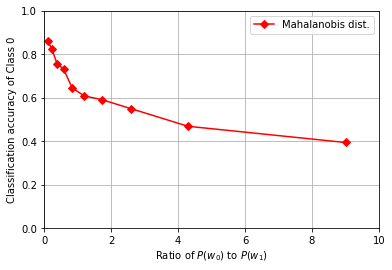

In [31]:
#minimum mahalanobis distance
Res = []  # save results
for pw0 in Pw0:
    
    res = mahalabolis_class(covs0, covs1, nf, pw0, nte)
    
    Res.append(res)
    
Res_arry = np.array(Res)  # conver 2d list to 2d array
                          # first col is prior prob of class 0
                          # second col is the accuracy of class 0
plt.plot(Res_arry[:,0]/(1 - Res_arry[:,0]), Res_arry[:,1], color = 'r', marker = 'D', label = 'Mahalanobis dist.')
plt.xlabel('Ratio of $P(w_0)$ to $P(w_1)$')
plt.ylabel('Classification accuracy of Class 0')
plt.legend()
plt.ylim([0,1])
plt.xlim([0,10])
plt.grid()
plt.savefig(r'../Figures/pm_mdist_2.jpg')

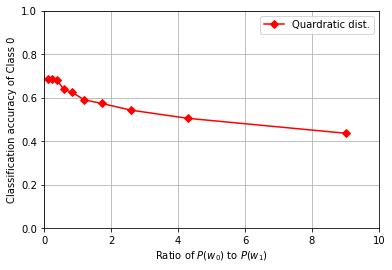

In [32]:
# generic form of Baysian decision rule
Res = []  # save results
for pw0 in Pw0:
    
    res = quadratic_class(covs0, covs1, nf, pw0, nte)
    
    Res.append(res)
    
Res_arry = np.array(Res)  # conver 2d list to 2d array
                          # first col is prior prob of class 0
                          # second col is the accuracy of class 0
plt.plot(Res_arry[:,0]/(1 - Res_arry[:,0]), Res_arry[:,1], color = 'r', marker = 'D', label = 'Quardratic dist.')
plt.xlabel('Ratio of $P(w_0)$ to $P(w_1)$')
plt.ylabel('Classification accuracy of Class 0')
plt.legend()
plt.ylim([0,1])
plt.xlim([0,10])
plt.grid()
plt.savefig(r'../Figures/pm_qdist_2.jpg')

### Bounus
For the synthetic dataset, if single-modal Gaussian is not the best model for the pdf, revise the model and report the performance.

The distribution of points in training set indicates there are two clusters. Thus, herein, a Gaussian Mixture Model with two compoenents is considered. To find out the mean and standard deviation of two clusters, training set is manually separated by a vertical line x = -0.3. Denote that the points left to this boundary is component 1, points right to this boundary is component 2. 


In [4]:
df_tr = pd.read_csv('http://www.stats.ox.ac.uk/pub/PRNN/synth.tr', delim_whitespace = True, header = 0)
df_te = pd.read_csv('http://www.stats.ox.ac.uk/pub/PRNN/synth.te', delim_whitespace = True, header = 0)

Xtrain = df_tr[['xs','ys']].to_numpy()
ytrain = df_tr['yc'].to_numpy().astype(int)

Xtest = df_te[['xs','ys']].to_numpy()
ytest = df_te['yc'].to_numpy().astype(int)

nte, nf = Xtest.shape    # get the dimension of testing samples
                         # nte is the number of testing samples
                         # nf is the number of features/dimensions

com1 = Xtrain[Xtrain[:,0] < -0.3,:]
com2 = Xtrain[Xtrain[:,0] >= -0.3,:]
com1_y = ytrain[Xtrain[:,0] <-0.3]
com2_y = ytrain[Xtrain[:,0] >= -0.3]

print("number of featues is: ",nf, "number of testing samples is:", nte, "number of training samples is:", Xtrain.shape[0])


URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [34]:
# get training samples for class 0
covavg = (covs0 + covs1) / 2               # average of Sigmas
varavg = np.sum(np.diagonal(covavg)) / nf  # average of vari

In [35]:
def get_com_statis(com_x, com_y):
    '''
    compute the mean and variance for each component
    '''
    
    arr = com_x[com_y == 0]
    covs0 = np.cov(np.transpose(arr))
    means0 = np.mean(arr, axis = 0)

    arr = com_x[com_y == 1]
    covs1 = np.cov(np.transpose(arr))
    means1 = np.mean(arr, axis = 0)
    
    return covs0, means0, covs1, means1

com1_0cov, com1_0mean, com1_1cov, com1_1mean = get_com_statis(com1, com1_y)
com2_0cov, com2_0mean, com2_1cov, com2_1mean = get_com_statis(com2, com2_y)

w1 = w2 = 0.5

In [36]:
# Euclidean distance 
t0 = time.time()
Pw0 = Pw1 = 0.5
covavg = (covs0 + covs1) / 2  
varavg = np.sum(np.diagonal(covavg) / nf)   # average of variances
y = []                     # save the classification label of testing samples

part11 = w1*1/(sympy.sqrt((2*sympy.pi)**2 * varavg)).evalf()
part12 = w2*1/(sympy.sqrt((2*sympy.pi)**2 * varavg)).evalf()

part21 = w1*1/(sympy.sqrt((2*sympy.pi)**2 * varavg)).evalf()
part22 = w2*1/(sympy.sqrt((2*sympy.pi)**2 * varavg)).evalf()

for i in range(nte):
    
    edist21 = np.dot(Xtest[i] - com1_0mean, Xtest[i] - com1_0mean)
    edist22 = np.dot(Xtest[i] - com2_0mean, Xtest[i] - com2_0mean)
    g0 =  sympy.log(part11 * sympy.exp(- edist21 / (2 * varavg)) + \
          part12 * sympy.exp(- edist22 / (2 * varavg)) ) + np.log(Pw0)

    
    edist21 = np.dot(Xtest[i] - com1_1mean, Xtest[i] - com1_1mean)
    edist22 = np.dot(Xtest[i] - com2_1mean, Xtest[i] - com2_1mean)
    g1 =  sympy.log(part21 * sympy.exp(- edist21 / (2 * varavg)) + \
          part22 * sympy.exp(- edist22 / (2 * varavg)) ) + np.log(Pw1)
    
    y.append(1) if g1 > g0 else y.append(0)

t1 = time.time()

acc_overall, acc0, acc1, runtime = model_evaluation(y, ytest, t1, t0)

Overall accuracy: 77.40% 
 Classwise accuracy of class 0: 97.90% 
 Classwise accuracy of class 1: 69.19% 
 Test finished in 2.6591 seconds


In [37]:
# mahalanobis distance 
t0 = time.time()
Pw0 = Pw1 = 0.5
covavg = (covs0 + covs1) / 2  
# varavg = np.sum(np.diagonal(covavg) / nf)   # average of variances
cov0avg = (com1_0cov + com2_0cov)/2 
cov1avg = (com1_1cov + com2_1cov)/2

part11 = w1*1/(sympy.sqrt((2*sympy.pi)**2 * np.linalg.det(cov0avg))).evalf()
part12 = w2*1/(sympy.sqrt((2*sympy.pi)**2 * np.linalg.det(cov1avg))).evalf()

part21 = w1*1/(sympy.sqrt((2*sympy.pi)**2 * np.linalg.det(cov0avg))).evalf()
part22 = w2*1/(sympy.sqrt((2*sympy.pi)**2 * np.linalg.det(cov1avg))).evalf()

y = []                     # save the classification label of testing samples

for i in range(nte):
    
    
    mdist21 = np.transpose(Xtest[i] - com1_0mean) @ np.linalg.inv(cov0avg) @ (Xtest[i] - com1_0mean)
    mdist22 = np.transpose(Xtest[i] - com2_0mean) @ np.linalg.inv(cov0avg) @ (Xtest[i] - com2_0mean)
    
    g0 =   sympy.log(part11 * sympy.exp(- mdist21 / 2)  + \
          part12 * sympy.exp(- mdist22 / 2))  + np.log(Pw0) 

    
    mdist21 = np.transpose(Xtest[i] - com1_1mean) @ np.linalg.inv(cov1avg) @ (Xtest[i] - com1_1mean)
    mdist22 = np.transpose(Xtest[i] - com2_1mean) @ np.linalg.inv(cov1avg) @ (Xtest[i] - com2_1mean)
    
    g1 =  sympy.log(part21 * sympy.exp(- mdist21 / 2)  + \
          part22 * sympy.exp(- mdist22 / 2))  + np.log(Pw1) 
    
    y.append(1) if g1 > g0 else y.append(0)

t1 = time.time()

acc_overall, acc0, acc1, runtime = model_evaluation(y, ytest, t1, t0)

Overall accuracy: 91.40% 
 Classwise accuracy of class 0: 92.42% 
 Classwise accuracy of class 1: 90.43% 
 Test finished in 2.9527 seconds


In [38]:
#quardratic 

t0 = time.time()
Pw0 = Pw1 = 0.5
y = []

part11 = w1*1/(sympy.sqrt((2*sympy.pi)**2 * np.linalg.det(com1_0cov))).evalf()
part12 = w2*1/(sympy.sqrt((2*sympy.pi)**2 * np.linalg.det(com2_0cov))).evalf()

part21 = w1*1/(sympy.sqrt((2*sympy.pi)**2 * np.linalg.det(com1_1cov))).evalf()
part22 = w2*1/(sympy.sqrt((2*sympy.pi)**2 * np.linalg.det(com2_1cov))).evalf()

for i in range(nte):
    
    qdist21 = np.transpose(Xtest[i] - com1_0mean) @ np.linalg.inv(com1_0cov) @ (Xtest[i] - com1_0mean)
    qdist22 = np.transpose(Xtest[i] - com2_0mean) @ np.linalg.inv(com2_0cov) @ (Xtest[i] - com2_0mean)

    
    g0 =  sympy.log(part11 * sympy.exp(- qdist21/2) + \
          part12 * sympy.exp(- qdist22/2)) + np.log(Pw0)           # mahalanobis distance 
    
    qdist21 = np.transpose(Xtest[i] - com1_1mean) @ np.linalg.inv(com1_1cov) @ (Xtest[i] - com1_1mean)
    qdist22 = np.transpose(Xtest[i] - com2_1mean) @ np.linalg.inv(com2_1cov) @ (Xtest[i] - com2_1mean)    
    
    g1 =  sympy.log(part21 * sympy.exp(- qdist21/2) + \
          part22 * sympy.exp(- qdist22/2)) + np.log(Pw1)           # mahalanobis distance
    
    y.append(1) if g1 > g0 else y.append(0)

t1 = time.time()
acc_overall, acc0, acc1, runtime = model_evaluation(y, ytest, t1, t0)

Overall accuracy: 91.30% 
 Classwise accuracy of class 0: 89.18% 
 Classwise accuracy of class 1: 93.66% 
 Test finished in 2.9560 seconds


## plot barchart for comparison

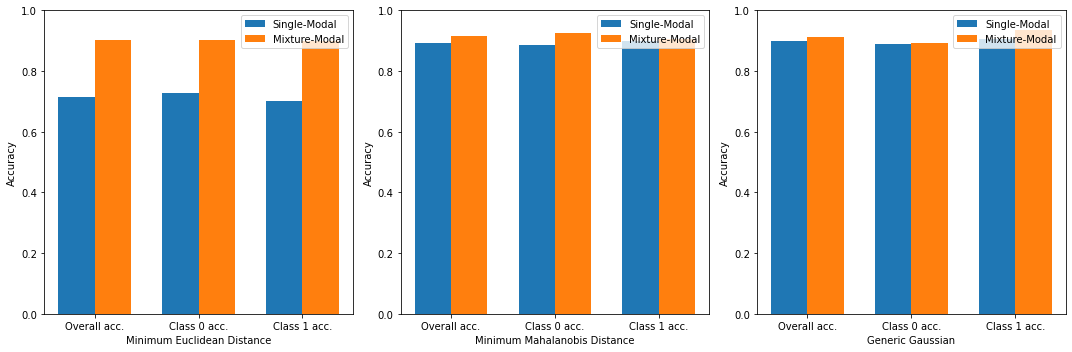

In [39]:
res_single = [[0.7130, 0.7281, 0.6998],
              [0.8920, 0.8858, 0.8984],
              [0.8980, 0.8902, 0.9061]]
res_mixture = [[0.9010, 0.9034,0.8986],
               [0.9140, 0.9242, 0.9043],
               [0.9130, 0.8918, 0.9366]]
labels = ['Overall acc.','Class 0 acc.','Class 1 acc.']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(1,3, figsize = (15,5))
rects1 = ax[0].bar(x - width/2, res_single[0], width, label='Single-Modal')
rects2 = ax[0].bar(x + width/2, res_mixture[0], width, label='Mixture-Modal')
ax[0].set_ylim([0,1])
ax[0].set_ylabel('Accuracy')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()
ax[0].set_xlabel('Minimum Euclidean Distance')

rects1 = ax[1].bar(x - width/2, res_single[1], width, label='Single-Modal')
rects2 = ax[1].bar(x + width/2, res_mixture[1], width, label='Mixture-Modal')
ax[1].set_ylim([0,1])
ax[1].set_ylabel('Accuracy')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()
ax[1].set_xlabel('Minimum Mahalanobis Distance')

rects1 = ax[2].bar(x - width/2, res_single[2], width, label='Single-Modal')
rects2 = ax[2].bar(x + width/2, res_mixture[2], width, label='Mixture-Modal')
ax[2].set_ylim([0,1])
ax[2].set_ylabel('Accuracy')
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)
ax[2].legend()
ax[2].set_xlabel('Generic Gaussian')
plt.tight_layout()
plt.savefig('../Figures/PerformanceComparison.jpg')